In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
### In this script, we will take care of the precision queries.

In [2]:

import sys
sys.path.append('/nethome/jbang36/eko')


In [3]:
### let's run the experiment and get the results
video_names = ['cherry960', 'ua_detra960', 'dashcam960', 'jackson']
video_name = 'jackson'
category = 'car'

from eko_paper2022.motivation.main import *

images = load_dataset(video_name)


10-27-2022 14:53:58 [info:049]INFO : meta data of the video /srv/data/jbang36/video_data/jackson/video.mp4 is (300000, 300, 300, 3)
meta data of the video /srv/data/jbang36/video_data/jackson/video.mp4 is (300000, 300, 300, 3)
100%|██████████| 300000/300000 [00:58<00:00, 5085.11it/s]


In [4]:
#### let's use eko and see what the y_pred, y_true gives

from eko_paper2022.motivation.main import execute_ekoalt
from eko_paper2022.experiments.main import *


eko = execute_ekoalt(images, video_name, nb_buckets = 70000)

from eko_paper2022.experiments.main import *


query = get_labels(eko)
a = query.y_pred
b = query.y_true
gt_retrieval = []
for bb in b:
    gt_retrieval.append(float(bb))
gt_retrieval = np.array(gt_retrieval)



index initializing....
number of training instances:  1
mining complete!
training complete!
inferring complete!
0.8 70000
rep indices stats 70000 60000
60001 70000
bucketing complete!


Target DNN Invocations:   0%|          | 0/60001 [00:00<?, ?it/s]

Propagation:   0%|          | 0/300000 [00:00<?, ?it/s]

In [5]:
query, times = query_process_aggregate(eko)

a = query.y_pred
b = query.y_true
gt_aggregate = []
for bb in b:
    gt_aggregate.append(float(bb))
gt_aggregate = np.array(gt_aggregate)

Propagation:   0%|          | 0/300000 [00:00<?, ?it/s]

r 4.0
NightStreetAggregateQuery
---------------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
initial_estimate             14945.0
debiased_estimate            12146.806814591122
nb_samples                   634
y_pred                       [          0           0           0 ...           0           0           0]
y_true                       [DNNOutputCacheFloat(idx=0) DNNOutputCacheFloat(idx=1) DNNOutputCacheFloat(idx=2) ... DNNOutputCacheFloat(idx=299997) DNNOutputCacheFloat(idx=299998) DNNOutputCacheFloat(idx=299999)]
actual_estimate              14860.0


In [6]:
images.shape,gt_retrieval.shape

((300000, 300, 300, 3), (300000,))

In [ ]:
#### now we go into individual methods and compute their numbers...
#### we will do precision and recall in 1 pass




#### SVM

In [7]:

from eko_paper2022.experiments.svm_wrapper import SVMWrapper


svm_wrapper = SVMWrapper()
labels = gt_aggregate

st = time.perf_counter()
svm_wrapper.train(images, labels)
et  = time.perf_counter()

et - st


SVM training start....
SVM training done!!


9.385698299854994

In [8]:
### svm_precision

svm_retrieval = svm_wrapper.inference_retrieval(images)

In [9]:
dnn_invocation = int(len(images) * 0.1)


In [10]:

precision, recall = query_process_precision(None, dnn_invocation = dnn_invocation, y = (svm_retrieval, gt_retrieval))
precision, recall

(1.0, 0.26521003457662035)

In [11]:
precision, recall = query_process_recall(None, dnn_invocation = dnn_invocation, y = (svm_retrieval, gt_retrieval))
precision, recall

(0.19706982919910676, 0.9608622084896637)

## Resnet-18

In [12]:
## Resnet-18

images.shape
### load the labels -- it's loading the csv file 
label_file = f'/srv/data/jbang36/video_data/{video_name}/tasti_labels.csv'

from eko_paper2022.experiments.resnet_wrapper import ResnetWrapper


resnet = ResnetWrapper()

labels = resnet._load_labels(images, label_file)



In [13]:
### okay, let's try the training step..
st = time.perf_counter()
resnet.train(images, labels)
et = time.perf_counter()

Epoch 1

Epoch [1/5], Step [0/750], Loss: 2.1881
Epoch [1/5], Step [20/750], Loss: 0.0476
Epoch [1/5], Step [40/750], Loss: 0.3996
Epoch [1/5], Step [60/750], Loss: 0.1043
Epoch [1/5], Step [80/750], Loss: 0.0472
Epoch [1/5], Step [100/750], Loss: 1.6048
Epoch [1/5], Step [120/750], Loss: 0.0016
Epoch [1/5], Step [140/750], Loss: 0.0280
Epoch [1/5], Step [160/750], Loss: 0.0014
Epoch [1/5], Step [180/750], Loss: 0.1926
Epoch [1/5], Step [200/750], Loss: 0.0145
Epoch [1/5], Step [220/750], Loss: 0.0026
Epoch [1/5], Step [240/750], Loss: 0.0228
Epoch [1/5], Step [260/750], Loss: 1.1017
Epoch [1/5], Step [280/750], Loss: 0.0029
Epoch [1/5], Step [300/750], Loss: 0.0137
Epoch [1/5], Step [320/750], Loss: 0.0004
Epoch [1/5], Step [340/750], Loss: 0.0307
Epoch [1/5], Step [360/750], Loss: 0.9070
Epoch [1/5], Step [380/750], Loss: 0.1448
Epoch [1/5], Step [400/750], Loss: 0.0685
Epoch [1/5], Step [420/750], Loss: 0.0008
Epoch [1/5], Step [440/750], Loss: 0.0000
Epoch [1/5], Step [460/750], Lo

In [14]:
et - st

22.634621389210224

In [15]:
resnet_retrieval = resnet.inference_retrieval(images, image_size = 224)

inference image size is  224
cuda


100%|██████████| 37500/37500 [09:25<00:00, 66.30it/s]


In [16]:

precision, recall = query_process_precision(None, dnn_invocation = dnn_invocation, y = (resnet_retrieval, gt_retrieval))
precision, recall


(1.0, 0.1975281394835577)

In [17]:
precision, recall = query_process_recall(None, dnn_invocation = dnn_invocation, y = (resnet_retrieval, gt_retrieval))
precision, recall


(0.04642637283586838, 0.9875671301405134)

### EKO

In [7]:
#### let's try eko

anchor_count = int( len(images) * 0.1 )

eko = execute_ekoalt(images, video_name, nb_buckets = anchor_count)


index initializing....
number of training instances:  1
mining complete!
training complete!
inferring complete!
0.8 30000
rep indices stats 30000 25000
25001 30000
bucketing complete!


Target DNN Invocations:   0%|          | 0/25001 [00:00<?, ?it/s]

In [8]:
### Q2:
dnn_invocation = int(len(images) * 0.1)

precision, recall = query_process_precision(eko, dnn_invocation = dnn_invocation)
precision, recall



Propagation:   0%|          | 0/300000 [00:00<?, ?it/s]

(0.7693693693693694, 0.7539174575148974)

In [9]:
### Q2:
precision, recall = query_process_recall(eko, dnn_invocation = dnn_invocation)
precision, recall



Propagation:   0%|          | 0/300000 [00:00<?, ?it/s]

(0.6966616541353383, 0.8520562053998382)

### TASTIPT

In [21]:
from eko_paper2022.motivation.main import execute_tastipt

tastipt = execute_tastipt(images, video_name, category = category, redo = False, image_size = 224, nb_buckets = anchor_count)



Image size is  224
index initializing....
number of training instances:  3000
Image size is  224
mining complete!
Image size is  224
training complete!
inferring complete!


100%|██████████| 300000/300000 [04:29<00:00, 1115.04it/s]


bucketing complete!


Target DNN Invocations:   0%|          | 0/30000 [00:00<?, ?it/s]

In [22]:
### Q2:
### Q2:
precision, recall = query_process_precision(tastipt, dnn_invocation = dnn_invocation)
precision, recall



Propagation:   0%|          | 0/300000 [00:00<?, ?it/s]

(0.6328441003120305, 0.8057088207165453)

In [23]:
### Q2:
precision, recall = query_process_recall(tastipt, dnn_invocation = dnn_invocation)
precision, recall



Propagation:   0%|          | 0/300000 [00:00<?, ?it/s]

(0.5552465702632555, 0.8813359817553152)

In [3]:
import numpy as np

In [4]:
def f1_score(precisions, recalls):
    f1s = []
    for precision, recall in zip(precisions, recalls):
        f1s.append(2* precision * recall / (precision + recall))
    return f1s

In [5]:
#### Q2



x_axis_names = ['SVM', 'Resnet-18', 'TASTI-PT', 'EKO']


cherry_p = np.array([0.99, 0.97, 0.94, 0.96]) 
cherry_r = np.array([0.19, 0.52, 0.91, 0.96])
cherry_f = f1_score(cherry_p, cherry_r)

detrac_p = np.array([1.0, 0.96, 0.96, 0.98]) 
detrac_r = np.array([0.90, 0.94, 0.98, 0.97])
detrac_f = f1_score(detrac_p, detrac_r)

dashcam_p = np.array([1.0, 0.96, 0.94, 0.95]) 
dashcam_r = np.array([0.09, 0.61, 0.87, 0.92])
dashcam_f = f1_score(dashcam_p, dashcam_r)

jackson_p = np.array([1.0, 1.0, 0.63, 0.77]) 
jackson_r = np.array([0.26, 0.19, 0.8, 0.75])
jackson_f = f1_score(jackson_p, jackson_r)


In [6]:
cherry_f, detrac_f, dashcam_f, jackson_f

([0.3188135593220339, 0.6770469798657718, 0.9247567567567566, 0.96],
 [0.9473684210526316,
  0.9498947368421051,
  0.9698969072164948,
  0.974974358974359],
 [0.16513761467889906,
  0.7459872611464969,
  0.903646408839779,
  0.93475935828877],
 [0.41269841269841273,
  0.319327731092437,
  0.7048951048951049,
  0.7598684210526316])

In [7]:
cherry_t = cherry_f
detrac_t = detrac_f
dashcam_t = dashcam_f
jackson_t = jackson_f

i = 0
svm_times = [cherry_t[i], detrac_t[i], dashcam_t[i], jackson_t[i]]
i = 1
resnet_times = [cherry_t[i], detrac_t[i], dashcam_t[i], jackson_t[i]]

i = 2
tasti_times = [cherry_t[i], detrac_t[i], dashcam_t[i], jackson_t[i]]

i = 3
eko_times = [cherry_t[i], detrac_t[i], dashcam_t[i], jackson_t[i]]

np.average(svm_times), np.average(resnet_times), np.average(tasti_times), np.average(eko_times)

(0.4610045019379943,
 0.6730641772367028,
 0.8757987944270338,
 0.9074005345789402)

In [8]:
90 / 46, 90 / 67, 90 / 87

(1.9565217391304348, 1.3432835820895523, 1.0344827586206897)

In [9]:
cherry_f[3] / cherry_f, detrac_f[3] / detrac_f, dashcam_f[3] / dashcam_f, jackson_f[3] / jackson_f

(array([3.01116427, 1.41792228, 1.03811083, 1.        ]),
 array([1.0291396 , 1.02640253, 1.00523504, 1.        ]),
 array([5.66048723, 1.25305003, 1.03443045, 1.        ]),
 array([1.84121964, 2.37958795, 1.07798794, 1.        ]))

<ipython-input-10-2a8fea29b543>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right',rotation_mode='anchor')
<ipython-input-10-2a8fea29b543>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')
<ipython-input-10-2a8fea29b543>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')
<ipython-input-10-2a8fea29b543>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')


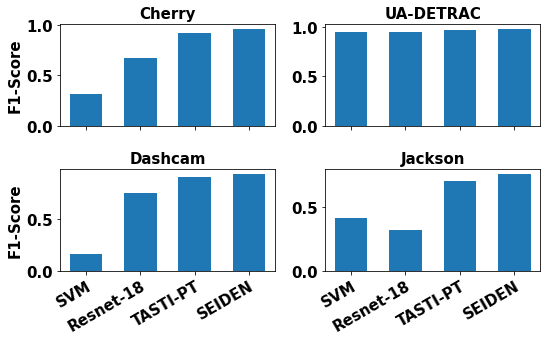

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

font = {
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=15)


x_axis_names = ['SVM', 'Resnet-18', 'TASTI-PT', 'SEIDEN']

x = np.arange(len(x_axis_names))


### we need to do subplots
rows = 2
columns = 2
fig_size = (8, 5)
fig, axes = plt.subplots(rows, columns, sharey = False, sharex=True, figsize=fig_size)


i = 0
j = 0
width = 0.6

axes[i][j].bar(x_axis_names, cherry_f, width)
axes[i][j].set_ylabel('F1-Score', weight = 'bold', size = 15)
#axes[i][j].set_ylim(0, 200)
#axes[i][j].set_yticks([0, 50, 100, 150, 200])

axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right',rotation_mode='anchor')
#plt.ylim(0, 2)
#plt.xticks(x, x_axis_names)
axes[i][j].set_title('Cherry', weight = 'bold', size = 15)


i = 0
j = 1
axes[i][j].bar(x_axis_names, detrac_f, width)
axes[i][j].set_title('UA-DETRAC', weight = 'bold', size = 15)
axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')


i = 1
j = 0
axes[i][j].bar(x_axis_names, dashcam_f, width)
axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')
axes[i][j].set_ylabel('F1-Score', weight = 'bold', size = 15)

axes[i][j].set_title('Dashcam', weight = 'bold', size = 15)


i = 1
j = 1
axes[i][j].bar(x_axis_names, jackson_f, width)

axes[i][j].set_title('Jackson', weight = 'bold', size = 15)
axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')


fig.tight_layout()

#plt.legend()
plt.savefig('plots/query-execution-q2.png')
plt.show()

## Q3

In [11]:
#### Q3



x_axis_names = ['SVM', 'Resnet-18', 'TASTI-PT', 'SEIDEN']


cherry_p = np.array([0.63, 0.42, 0.91, 0.96]) 
cherry_r = np.array([0.96, 0.96, 0.92, 0.95])
cherry_f = f1_score(cherry_p, cherry_r)

detrac_p = np.array([0.94, 0.96, 0.98, 0.98]) 
detrac_r = np.array([0.96, 0.95, 0.95, 0.95])
detrac_f = f1_score(detrac_p, detrac_r)

dashcam_p = np.array([0.6, 0.7, 0.92, 0.95]) 
dashcam_r = np.array([0.96, 0.96, 0.91, 0.94])
dashcam_f = f1_score(dashcam_p, dashcam_r)

jackson_p = np.array([0.19, 0.04, 0.55, 0.70]) 
jackson_r = np.array([0.96, 0.98, 0.88, 0.85])
jackson_f = f1_score(jackson_p, jackson_r)

In [12]:
cherry_t = cherry_f
detrac_t = detrac_f
dashcam_t = dashcam_f
jackson_t = jackson_f

i = 0
svm_times = [cherry_t[i], detrac_t[i], dashcam_t[i], jackson_t[i]]
i = 1
resnet_times = [cherry_t[i], detrac_t[i], dashcam_t[i], jackson_t[i]]

i = 2
tasti_times = [cherry_t[i], detrac_t[i], dashcam_t[i], jackson_t[i]]

i = 3
eko_times = [cherry_t[i], detrac_t[i], dashcam_t[i], jackson_t[i]]

np.average(svm_times), np.average(resnet_times), np.average(tasti_times), np.average(eko_times)

(0.6915820958972809,
 0.6064557368478479,
 0.8679088178731431,
 0.9081140354562958)

In [13]:
91 / 69, 91 / 60, 91 / 87

(1.318840579710145, 1.5166666666666666, 1.0459770114942528)

In [14]:
cherry_f

[0.7607547169811322,
 0.5843478260869565,
 0.9149726775956284,
 0.9549738219895287]

<ipython-input-15-21a570e9b1d7>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right',rotation_mode='anchor')
<ipython-input-15-21a570e9b1d7>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')
<ipython-input-15-21a570e9b1d7>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')
<ipython-input-15-21a570e9b1d7>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')


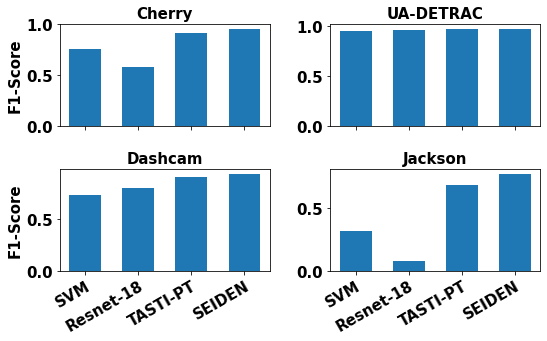

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

font = {
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=15)


x_axis_names = ['SVM', 'Resnet-18', 'TASTI-PT', 'SEIDEN']

x = np.arange(len(x_axis_names))


### we need to do subplots
rows = 2
columns = 2
fig_size = (8, 5)
fig, axes = plt.subplots(rows, columns, sharey = False, sharex=True, figsize=fig_size)


i = 0
j = 0
width = 0.6

axes[i][j].bar(x_axis_names, cherry_f, width)
axes[i][j].set_ylabel('F1-Score', weight = 'bold', size = 15)
#axes[i][j].set_ylim(0, 200)
#axes[i][j].set_yticks([0, 50, 100, 150, 200])

axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right',rotation_mode='anchor')
#plt.ylim(0, 2)
#plt.xticks(x, x_axis_names)
axes[i][j].set_title('Cherry', weight = 'bold', size = 15)


i = 0
j = 1
axes[i][j].bar(x_axis_names, detrac_f, width)
axes[i][j].set_title('UA-DETRAC', weight = 'bold', size = 15)
axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')


i = 1
j = 0
axes[i][j].bar(x_axis_names, dashcam_f, width)
axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')
axes[i][j].set_ylabel('F1-Score', weight = 'bold', size = 15)

axes[i][j].set_title('Dashcam', weight = 'bold', size = 15)


i = 1
j = 1
axes[i][j].bar(x_axis_names, jackson_f, width)

axes[i][j].set_title('Jackson', weight = 'bold', size = 15)
axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')


fig.tight_layout()

#plt.legend()
plt.savefig('plots/query-execution-q3.png')
plt.show()

In [55]:
### Cherry Q1
cherry_q1 = np.array([3341, 2352, 1900, 1759]) * (1 / 140) + np.array([0, 0, 4.2, 4])
cherry_q2 = np.array([-1, -1, 300, 300]) * 1 / 140 + np.array([0, 0, 4.2, 4])
cherry_q3 = np.array([100, 100, 100, 600]) * 1 / 140 + np.array([0, 0, 4.2, 4])
detrac_q1 = np.array([55607, 28323, 23147, 20943]) * (1 / 140) + np.array([0, 0, 3.9, 4.5])
detrac_q2 = np.array([210, 210, 210, 210]) * (1 / 140) + np.array([0, 0, 3.9, 4.5])
detrac_q3 = np.array([100, 100, 110, 100]) * (1 / 140) + np.array([0, 0, 3.9, 4.5])

dashcam_q1 = np.array([20679, 14638, 8426, 7571]) * (1 / 140) + np.array([0, 0, 3.7, 3.9])
dashcam_q2 = np.array([-1, -1, 240, 210]) * (1 / 140) + np.array([0, 0, 3.7, 3.9])
dashcam_q3 = np.array([100, 100, 100, 100]) * (1 / 140) + np.array([0, 0, 3.7, 3.9])

dashcam_q1 = np.array([1316, 921, 1145, 1425]) * (1 / 140) + np.array([0, 0, 13, 12])
dashcam_q2 = np.array([-1, -1, -1, -1]) * (1 / 140) + np.array([0, 0, 13, 12])
dashcam_q3 = np.array([1500, 17600, -1, -1]) * (1 / 140) + np.array([0, 0, 13, 12])


In [56]:
dashcam_q1

array([        9.4,      6.5786,      21.179,      22.179])

In [ ]:
THR = 1 / 140


#### Q1
x_axis_names = ['SVM', 'Resnet-18', 'TASTI-PT', 'EKO']
cherry_q1_others = [0, 0, 4.2, 3.9]
cherry_q1_post = [3300 * THR, 2545 * THR, 1892 * THR, 1829 * THR]

#### Q2
cherry_q2_others = [0, 0, 4.2, 3.9]
cherry_q2_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]

#### Q3
cherry_q3_others = [0, 0, 4.2, 3.9]
cherry_q3_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q1
detrac_q1_others = [0, 0, 4.2, 3.9]
detrac_q1_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q2
detrac_q2_others = [0, 0, 4.2, 3.9]
detrac_q2_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q3
detrac_q3_others = [0, 0, 4.2, 3.9]
detrac_q3_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q1
dashcam_q1_others = [0, 0, 4.2, 3.9]
dashcam_q1_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q2
dashcam_q2_others = [0, 0, 4.2, 3.9]
dashcam_q2_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q3
dashcam_q3_others = [0, 0, 4.2, 3.9]
dashcam_q3_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q1
jackson_q1_others = [0, 0, 4.2, 3.9]
jackson_q1_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q2
jackson_q2_others = [0, 0, 4.2, 3.9]
jackson_q2_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q3
jackson_q3_others = [0, 0, 4.2, 3.9]
jackson_q3_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]



import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


### we need to do subplots
rows = 1
columns = 3
i = 1
fig = plt.figure(figsize = (15,3))
fig.add_subplot(rows, columns, i)
plt.bar(x - width, cherry_values, width, label = 'Cherry')
plt.bar(x, ua_values, width, label = 'UA_DETRAC')
plt.bar(x + width, da_values, width, label = 'Dashcam')
plt.ylabel('Time (s)')
plt.xticks(x, x_axis_names)
plt.title('Q1 -- Aggregate')


i = 2
fig.add_subplot(rows, columns, i)
plt.bar(x - width, cherry_values, width, label = 'Cherry')
plt.bar(x, ua_values, width, label = 'UA_DETRAC')
plt.bar(x + width, da_values, width, label = 'Dashcam')
plt.xticks(x, x_axis_names)
plt.title('Q2 -- Precision')



i = 3
fig.add_subplot(rows, columns, i)
plt.bar(x - width, cherry_values, width, label = 'Cherry')
plt.bar(x, ua_values, width, label = 'UA_DETRAC')
plt.bar(x + width, da_values, width, label = 'Dashcam')
plt.xticks(x, x_axis_names)
plt.title('Q3 -- Recall')




plt.xticks(x, x_axis_names)
plt.legend()
plt.show()



In [ ]:
### TODO: Need to include the YOLOv5 inference time for EKO -- this is pretty significant

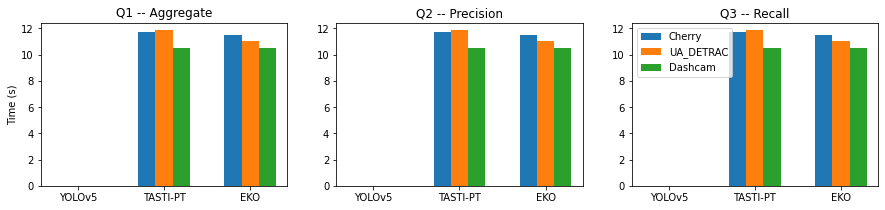

In [14]:
### generate the outcome graph first 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
### drawing function for the graph

#### Q1 values

x_axis_names = ['YOLOv5', 'TASTI-PT', 'EKO']
cherry_values = [0, 9.68, 9.5]
ua_values = [0, 61.25, 65.4]
da_values = [0, 3.3 + 21.47, 2.9 + 22.17]


##### Q2 values
cherry_values = [0, 4.48 + 7.14, 4.26 + 7.14]
ua_values = [0, 11.18, 12.94]
da_values = [0, 3.57 + 7.14, 3.4 + 7.14]

##### Q3 values
cherry_values = [0, 4.56 + 7.14, 4.32 + 7.14]
ua_values = [0, 11.84, 11.04]
da_values = [0, 3.4 + 7.14, 3.4 + 7.14]


x = np.arange(len(x_axis_names))
width = 0.2


### we need to do subplots
rows = 1
columns = 3
i = 1
fig = plt.figure(figsize = (15,3))
fig.add_subplot(rows, columns, i)
plt.bar(x - width, cherry_values, width, label = 'Cherry')
plt.bar(x, ua_values, width, label = 'UA_DETRAC')
plt.bar(x + width, da_values, width, label = 'Dashcam')
plt.ylabel('Time (s)')
plt.xticks(x, x_axis_names)
plt.title('Q1 -- Aggregate')





i = 2
fig.add_subplot(rows, columns, i)
plt.bar(x - width, cherry_values, width, label = 'Cherry')
plt.bar(x, ua_values, width, label = 'UA_DETRAC')
plt.bar(x + width, da_values, width, label = 'Dashcam')
plt.xticks(x, x_axis_names)
plt.title('Q2 -- Precision')



i = 3
fig.add_subplot(rows, columns, i)
plt.bar(x - width, cherry_values, width, label = 'Cherry')
plt.bar(x, ua_values, width, label = 'UA_DETRAC')
plt.bar(x + width, da_values, width, label = 'Dashcam')
plt.xticks(x, x_axis_names)
plt.title('Q3 -- Recall')




plt.xticks(x, x_axis_names)
plt.legend()
plt.show()


In [15]:
cherry_values = [0, 9.68, 9.5]
ua_values = [0, 61.25, 65.4]
da_values = [0, 3.3 + 21.47, 2.9 + 22.17]


##### Q2 values
cherry_values2 = [0, 4.48 + 7.14, 4.26 + 7.14]
ua_values2 = [0, 11.18, 12.94]
da_values2 = [0, 3.57 + 7.14, 3.4 + 7.14]

##### Q3 values
cherry_values3 = [0, 4.56 + 7.14, 4.32 + 7.14]
ua_values3 = [0, 11.84, 11.04]
da_values3 = [0, 3.4 + 7.14, 3.4 + 7.14]

In [17]:
tmp = np.array([cherry_values, ua_values, da_values, cherry_values2, ua_values2, da_values2, cherry_values3, ua_values3, da_values3])
tmp.mean(axis = 0)

array([          0,      18.143,      18.654])

In [18]:
print('hello world')

hello world
